In [1]:
import torch

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

In [2]:
import torch
import pandas as pd 

feature_indexes = [
    1,  # distance_from_last_transaction
    2,  # ratio_to_median_purchase_price
    4,  # used_chip
    5,  # used_pin_number
    6,  # online_order
]

label_indexes = [7]

# feature_columns = [
#     "distance_from_last_transaction",
#     "ratio_to_median_purchase_price",
#     "used_chip",
#     "used_pin_number",
#     "online_order",
# ]

# label_column = ["fraud"]

train_df = pd.read_csv('data/train.csv', )
# labels_df = train_df.loc[:, label_column]
# train_df = train_df.loc[:, feature_columns]
labels_df = train_df.iloc[:, label_indexes]
train_df = train_df.iloc[:, feature_indexes]
train_df_tensor = torch.tensor(train_df.values, dtype=torch.float).to(device)
labels_df_tensor = torch.tensor(labels_df.values, dtype=torch.float).to(device)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

train_df = pd.read_csv('data/train.csv', )
# labels_df = train_df.loc[:, label_column]
# train_df = train_df.loc[:, feature_columns]
labels_df = train_df.iloc[:, label_indexes]
train_df = train_df.iloc[:, feature_indexes]

sk_scaler = StandardScaler()
sk_scaler.fit(train_df)
sk_scaler.mean_, sk_scaler.scale_

(array([5.06362607, 1.82498702, 0.351165  , 0.10034833, 0.650395  ]),
 array([28.19476586,  2.79741583,  0.47733441,  0.30046388,  0.4768452 ]))

In [4]:
import torch


# like scikit learn standard scaler
class TorchStandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, tensor):
        self.mean = tensor.mean(dim=0, keepdim=False)
        self.std = tensor.std(dim=0, keepdim=False)

    def transform(self, tensor):
        return (tensor - self.mean) / self.std

    def fit_transform(self, tensor):
        self.fit(tensor)
        return self.transform(tensor)


train_df_tensor = torch.tensor(train_df.values, dtype=torch.float).to(device)
scaler = TorchStandardScaler()
scaler.fit(train_df_tensor)
scaler.mean, scaler.std

(tensor([5.0636, 1.8250, 0.3512, 0.1003, 0.6504], device='cuda:0'),
 tensor([28.1948,  2.7974,  0.4773,  0.3005,  0.4768], device='cuda:0'))

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.feature_indexes = feature_indexes
        self.label_indexes = label_indexes
        # self.feature_columns = feature_columns
        # self.label_column = label_column 
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.data.iloc[idx, self.feature_indexes],
                                dtype=torch.float32).to(device)
        label = torch.tensor(self.data.iloc[idx, self.label_indexes],
                             dtype=torch.float32).to(device)
        # features = torch.tensor(self.data.loc[idx, self.feature_columns],
        #                         dtype=torch.float32).to(device)
        # label = torch.tensor(self.data.loc[idx, self.label_column],
        #                      dtype=torch.float32)
        if self.transform:
            features = self.transform(features)
        if self.target_transform:
            label = self.target_transform(label)

        return features, label


training_data = CSVDataset('data/train.csv', transform=scaler.transform)
validation_data = CSVDataset('data/validate.csv', transform=scaler.transform)
# training_data = CSVDataset('data/train.csv', transform=sk_scaler.transform)
# validation_data = CSVDataset('data/validate.csv', transform=sk_scaler.transform)
# test_data = CSVDataset('data/test.csv', transform=sk_scaler.transform)

In [6]:
from torch.utils.data import DataLoader

batch_size = 10000

training_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)

In [7]:
import torch
from torch import nn

first_layer_num = len(training_data.feature_indexes)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(first_layer_num, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [30]:
# Initialize the loss function
labels_df_tensor = torch.tensor(labels_df.values, dtype=torch.float)
positives = torch.sum(labels_df_tensor)
negatives = (len(labels_df_tensor) - torch.sum(labels_df_tensor))
pos_weight = torch.unsqueeze((negatives / positives), 0)
print(pos_weight)

# loss_fn = nn.BCEWithLogitsLoss().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn

tensor([10.4210])


BCEWithLogitsLoss()

In [9]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


In [10]:
def accuracy_fn(y_pred, y_actual):
    correct = torch.eq(torch.round(y_pred), y_actual).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
# i = iter(training_dataloader)

# X, y = next(i)
# print(f"Feature batch shape: {X.size()}")
# print(f"Labels batch shape: {y.size()}")
# features = X[0]
# print(f"Features: {features}")
# label = y[0]
# print(f"Label: {label}")

# model.eval()
# with torch.inference_mode():
#     y_pred = model(X)
#     acc = accuracy_fn(y_pred, y)
#     loss = loss_fn(y_pred, y)

# print(y_pred[:10])
# print(torch.round(y_pred[:10]))
# print(y[:10])

# print(acc)
# print(loss)

In [27]:
def train_loop(dataloader, model, loss_fn, optimizer):
    global print_stuff
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % (size / batch_size / 10) == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.eq(torch.round(pred), y).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to
`train_loop` and `test_loop`. Feel free to increase the number of epochs
to track the model\'s improving performance.


In [28]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[ 0.1751, -0.3352, -0.1936,  0.1880,  0.2658],
                      [ 0.2717,  0.0024,  0.1191,  0.1804,  0.2486],
                      [-0.2196, -0.4380,  0.4206,  0.1622,  0.4142],
                      [-0.3802,  0.4550,  0.1082,  0.2396, -0.1002],
                      [-0.2344, -0.2133,  0.3611,  0.2119, -0.3261],
                      [-0.1004, -0.2784,  0.3351, -0.3985, -0.1822],
                      [-0.3950,  0.3103, -0.1508, -0.4061, -0.3373],
                      [-0.0993,  0.1186,  0.0580,  0.2722, -0.2149]], device='cuda:0')),
             ('linear_relu_stack.0.bias',
              tensor([-0.3365, -0.3905, -0.3989, -0.1590,  0.0177,  0.0751, -0.0144, -0.3212],
                     device='cuda:0')),
             ('linear_relu_stack.2.weight',
              tensor([[-0.1788, -0.3086, -0.3166, -0.1382,  0.2126,  0.1384, -0.2066,  0.3537],
                      [-0.1943, -0.2626, -0.2344,  0.0501,  0.2336,

In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_dataloader, model, loss_fn, optimizer)
    test_loop(validation_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/tmp/ipykernel_268/307709274.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features = torch.tensor(self.data.iloc[idx, self.feature_indexes],
/tmp/ipykernel_268/307709274.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(self.data.iloc[idx, self.label_indexes],


loss: 1.310119  [10000/600000]
loss: 1.311231  [70000/600000]
loss: 1.307011  [130000/600000]
loss: 1.294862  [190000/600000]
loss: 1.290341  [250000/600000]
loss: 1.308722  [310000/600000]
loss: 1.307042  [370000/600000]
loss: 1.313182  [430000/600000]
loss: 1.293027  [490000/600000]
loss: 1.308857  [550000/600000]
Test Error: 
 Accuracy: 81.1%, Avg loss: 1.304918 

Epoch 2
-------------------------------
loss: 1.306494  [10000/600000]
loss: 1.307494  [70000/600000]
loss: 1.303300  [130000/600000]
loss: 1.291063  [190000/600000]
loss: 1.286553  [250000/600000]
loss: 1.305040  [310000/600000]
loss: 1.303301  [370000/600000]
loss: 1.309403  [430000/600000]
loss: 1.289252  [490000/600000]
loss: 1.305099  [550000/600000]
Test Error: 
 Accuracy: 92.9%, Avg loss: 1.301185 

Epoch 3
-------------------------------
loss: 1.302797  [10000/600000]
loss: 1.303669  [70000/600000]
loss: 1.299508  [130000/600000]
loss: 1.287194  [190000/600000]
loss: 1.282697  [250000/600000]
loss: 1.301273  [31000

In [15]:
# test_loop(validation_dataloader, model, loss_fn)


In [16]:
def run_inference(test_data):
    model.eval()
    with torch.inference_mode():
        prediction = torch.round(model(test_data))

    if prediction.item() == 1:
        return "fraud"
    else:
        return "NOT fraud"

In [17]:
# valid transaction
valid_tx = torch.tensor([[0.0, 1.0, 1.0, 1.0, 0.0]]).to(device)
prediction = run_inference(valid_tx)
print(f"The model thinks the valid transaction is {prediction}")

The model thinks the valid transaction is fraud


In [18]:
# fraudulent use case
fraud_tx = torch.tensor([[100, 1.2, 0.0, 0.0, 1.0]]).to(device)
prediction = run_inference(fraud_tx)
print(f"The model thinks the valid transaction is {prediction}")

The model thinks the valid transaction is fraud


In [19]:
test_df = pd.read_csv('data/test.csv', )
test_labels_df = test_df.iloc[:, label_indexes]
test_data_df = test_df.iloc[:, feature_indexes]
test_data_df_tensor = torch.tensor(test_data_df.values, dtype=torch.float).to(device)
test_labels_df_tensor = torch.tensor(test_labels_df.values, dtype=torch.float).to(device)

In [20]:
### Testing
model.eval()
with torch.inference_mode():
    y_pred = model(test_data_df_tensor)
    acc = accuracy_fn(y_pred, test_labels_df_tensor)

print(acc)

8.691500000000001


Accuracy: 8.691500000000001


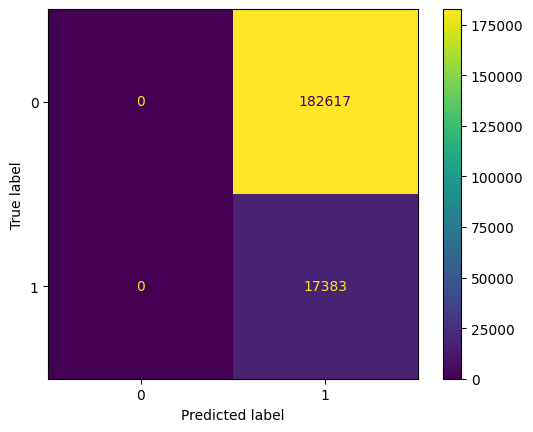

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

print(f"Accuracy: {acc}")

c_matrix = confusion_matrix(torch.Tensor.cpu(test_labels_df_tensor),
                            torch.round(torch.Tensor.cpu(y_pred)))
ConfusionMatrixDisplay(c_matrix).plot()
